# 6-1 文字資料處理

### 程式 6.1 單字的 one-hot encoding (簡易版)

In [3]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']  # 初始資料：每一個樣本是一個輸入項目(在這範例中，樣本是一個句子，但也可以是整個文件)

token_index = {}  # 建立資料中所有 tokens 的索引
for sample in samples:
    for word in sample.split():  # 透過 split()方法對樣本進行分詞。在真實案例中，還要移除樣本中的標點符號與特殊字元
        if word not in token_index:
            token_index[word] = len(token_index) + 1  # 為每個文字指定一個唯一索引。請注意，不要把索引 0 指定給任何文字

max_length = 10  # 將樣本向量化。每次只專注處理每個樣本中的第一個 max_length 文字

results = np.zeros(shape=(len(samples),  # 用來儲存結果的 Numpy array
                          max_length,
                          max(token_index.values()) + 1))  
print(results.shape) # shape=(2, 10, 11), 共 2 個樣本, 每個樣本只看前 10 個文字, 總樣本共有 10 個 token, 索引號到 11, 因為 0 不用。
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
print(token_index)

(2, 10, 11)
{'The': 1, 'cat': 2, 'sat': 3, 'on': 4, 'the': 5, 'mat.': 6, 'dog': 7, 'ate': 8, 'my': 9, 'homework.': 10}


### 程式 6.2 字元的 one-hot encoding (簡易版)

In [ ]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 所有可印出的 ASCII 字元的字串, '0123456789abc....'
print(len(characters))

token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
print(results.shape) 

for i, sample in enumerate(samples):
	for j, character in enumerate(sample):
		index = token_index.get(character)
		results[i, j, index] = 1.
print(results[0][0])

### 程式 6.3 用 Keras 做文字的 one-hot encoding

In [1]:
from keras.preprocessing.text import Tokenizer  # 匯入 Keras 分詞器

samples = ['The cat sat on the mat.', 'The dog ate my homework.']  # 初始資料

tokenizer = Tokenizer(num_words=1000) # 1. 建立一個分詞器, 設定上僅考慮 1, 000 個最常用的文字 (token), 也就是只會看初始資料的前 1000 個文字
tokenizer.fit_on_texts(samples)  # 建立文字對應的索引值, 一樣依出現順序來決定, 0 一樣不使用

sequences = tokenizer.texts_to_sequences(samples)  # 將初始資料中的文字轉換成對應的索引值 list
print(sequences) # [[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')  # 可以直接取得 one-hot 的二進位表示方式。此分詞 tokenizer 支援除了 one-hot 編碼以外, 也有支援其他的向量化方法
print(one_hot_results.shape) # (2, 1000) 共 2 個樣本, 每個樣本中的文字對應到的 token 位置 (1000個)
word_index = tokenizer.word_index  # 計算完成後, 取得文字與索引間的對應關聯 
print(word_index) # {'the': 1, 'cat': 2, 'sat': 3, ... 'my': 8, 'homework': 9}
print('找到 %s 個唯一的 tokens.' % len(word_index)) 


[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
(2, 1000)
{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
找到 9 個唯一的 tokens.


### 程式 6.4 使用雜湊技巧的單字 one-hot encoding (簡易版本)


In [4]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 #  將文字儲存成大小為 1, 000 的向量。如果有接近 1, 000 個文字(或更多), 將會造成許多雜湊碰撞, 這會降低此編碼方法的準確性
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
	for j, word in list(enumerate(sample.split()))[:max_length]:
		index = abs(hash(word)) % dimensionality # ← 將文字雜湊成 0 到 1, 000 之間的隨機整數索引
		results[i, j, index] = 1.
print(results.shape)

(2, 10, 1000)


### 使用嵌入向量層學習文字嵌入向量

### 程式 6.5 建立一個嵌入層 (Embedding Layer)

In [5]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)  # 建立嵌入向量層至少須指定兩個參數：可能的 tokens 數量 (此處為 1, 000, 最少是 1+最大文字索引) 和嵌入向量的維數 (此處為 64)

### 程式 6.6 載入 IMDB, 整理成適合供 Embedding 層使用的資料


In [6]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000  # ←設定作為特徵的文字數量
maxlen = 20 # ←在 20 個文字之後切掉文字資料 (在 max_features 最常見的文字中)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)  # ←將資料以整數 lists 載入
print(x_train.shape)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)  # ←將整數 lists 轉換為 2D 整數張量, 形狀為(樣本數 samples, 最大長度 maxlen)
print(x_train.shape)
print(x_train[0])
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)


(25000,)
(25000, 20)
[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32
   15   16 5345   19  178   32]


### 程式 6.7 把 IMDB 資料提供給 Embedding layer和分類器

In [7]:
# 1. 指定嵌入向量層的最大輸入長度, 以便之後可以攤平嵌入向量的輸入。在嵌入向量層之後, 啟動函數輸出的 shape 為 (樣本數 samples, 最大長度 maxlen, 8）
# 2. 將嵌入向量的 3D 張量展平為 2D 張量, 形狀為(樣本數 samples, 最大長度 maxlen * 8)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen)) # ←1...

model.add(Flatten()) # ← 2...

model.add(Dense(1, activation='sigmoid')) # ← 在頂部加上分類器
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, 
                    y_train,epochs=10,
                    batch_size=32,
                    validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.6693 - acc: 0.6225 - val_loss: 0.6206 - val_acc: 0.6998
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5455 - acc: 0.7509 - val_loss: 0.5294 - val_acc: 0.7302
Epoch 3/10
625/625 [==============================] 

### 使用預先訓練的文字嵌入向量

### 程式 6.8 處理原始 IMDB 資料的標籤

In [1]:
import os

imdb_dir = r'..\..\training_data\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)



In [2]:
print(len(texts))

25000


### 程式 6.9 對原始 IMDB 資料的文字資料進行向量化

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100 個文字後切斷評論 (只看評論的前 100 個字)
training_samples = 200  # 以 200 個樣本進行訓練
validation_samples = 10000 # 以 10, 000 個樣本進行驗證
max_words = 10000  # 僅考慮資料集中的前 10, 000 個單詞

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # 將文字轉成整數 list 的序列資料

word_index = tokenizer.word_index
# print(word_index[: 10])
print('共使用了 %s 個 token 字詞.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen) # 只取每個評論的前 100 個字 (多切少補) 作為資料張量
labels = np.asarray(labels)  # 將標籤 list 轉為 Numpy array (標籤張量)

print('資料張量 shape:', data.shape) # (25000, 100)
print('標籤張量 shape:', labels.shape) # (25000,)

indices = np.arange(data.shape[0])  # 將資料拆分為訓練集和驗證集, 但首先要將資料打散, 因為所處理的資料是有順序性的樣本資料 (負評在前, 然後才是正評)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_train.shape

共使用了 88582 個 token 字詞.
資料張量 shape: (25000, 100)
標籤張量 shape: (25000,)


(200, 100)

### 程式 6.10 解析 GloVe 文字嵌入向量檔案

In [9]:
glove_dir = r'..\..\pretrained_models\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('共有 %s 個文字嵌入向量' % len(embeddings_index))


共有 400000 個文字嵌入向量


### 程式 6.11 準備 GloVe 文字嵌入向量矩陣

In [10]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # ←嵌入向量索引中找不到的文字將為 0

### 程式 6.12 模型定義

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
# 參數 樣本數, 嵌入向量維度, 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


###  將預訓練的文字嵌入向量載入到嵌入向量層中

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False 

### 程式 6.13 訓練和驗證

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 99ms/step - loss: 1.6190 - acc: 0.4850 - val_loss: 0.8517 - val_acc: 0.5013
Epoch 2/10
7/7 [==============================] - 1s 84ms/step - loss: 0.5572 - acc: 0.7700 - val_loss: 1.5429 - val_acc: 0.5013
Epoch 3/10
7/7 [==============================] - 0s 80ms/step - loss: 0.6199 - acc: 0.7900 - val_loss: 0.9158 - val_acc: 0.4990
Epoch 4/10
7/7 [==============================] - 0s 78ms/step - loss: 0.3701 - acc: 0.9000 - val_loss: 0.7195 - val_acc: 0.4999
Epoch 5/10
7/7 [==============================] - 0s 81ms/step - loss: 0.3277 - acc: 0.9000 - val_loss: 0.7185 - val_acc: 0.5029
Epoch 6/10
7/7 [==============================] - 0s 81ms/step - loss: 0.2772 - acc: 0.9150 - val_loss: 0.7819 - val_acc: 0.5002
Epoch 7/10
7/7 [==============================] - 0s 77ms/step - loss: 0.2257 - acc: 0.9500 - val_loss: 0.7488 - val_acc: 0.5077
Epoch 8/10
7/7 [==============================] - 1s 84ms/step - loss: 0.1459 - acc: 0.9900 - val

### 程式 6.14 繪製結果

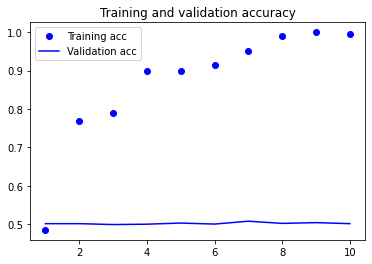

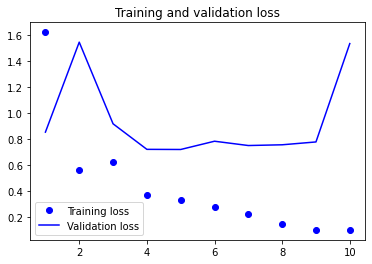

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### 程式 6.15 訓練相同模型而不使用預先訓練的文字嵌入向量

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 89ms/step - loss: 0.6930 - acc: 0.4800 - val_loss: 0.6935 - val_acc: 0.5040
Epoch 2/10
7/7 [==============================]

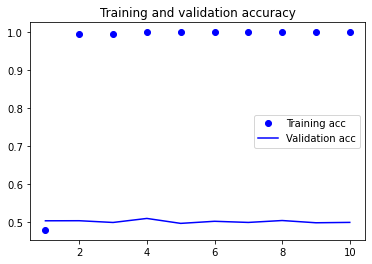

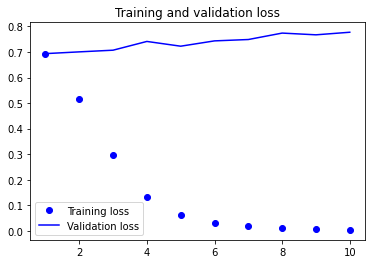

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


############### 繪製
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 程式 6.16 對測試資料進行分詞

In [16]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
	dir_name = os.path.join(test_dir, label_type)
	for fname in sorted(os.listdir(dir_name)):
		if fname[-4:] == '.txt':
			f = open(os.path.join(dir_name, fname), encoding='UTF-8')
			texts.append(f.read())
			f.close()
			if label_type == 'neg':
				labels.append(0)
			else:
				labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [17]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 1.5525 - acc: 0.4996


[1.5524896383285522, 0.49963998794555664]

# 6-2 了解遞歸神經網路

### 程式 6.17 以 Numpy 實現簡單的 RNN

In [ ]:
import numpy as np

timesteps = 100   # 輸入序列資料中的時間點數量
input_features = 32  # 輸入特徵空間的維度數
output_features = 64  # 輸出特徵空間的維度數

inputs = np.random.random((timesteps, input_features))  # 輸入資料：隨機產生數值以便示範

state_t = np.zeros((output_features, ))  # 初始狀態：全零向量

W = np.random.random((output_features, input_features))  # 建立隨機權重矩陣
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:  #  input_t 是個向量, shape 為 (input_features, )
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # 結合輸入與當前狀態(前一個輸出)以取得當前輸出
    successive_outputs.append(output_t)  # 將此輸出儲存在列表中
    state_t = output_t  #更新下一個時間點的網絡狀態

final_output_sequence = np.concatenate(successive_outputs, axis=0)  
print(final_output_sequence.shape)


### 程式 6.18 準備 IMDB 資料

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  #考慮做為特徵的文字數量
maxlen = 500  # 我們只看每篇評論的前 500 個文字

batch_size = 32

print('讀取資料...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences') # 25000 筆訓練用序列資料 (評論)
print(len(input_test), 'test sequences')	# 25000 筆測試用序列資料

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen) # 1. 只看每篇評論的前 500 個文字, 多的去除, 不足填補
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)	# shape=(25000, 500)
print('input_test shape:', input_test.shape)	# shape=(25000, 500)



### 程式 6.19 以嵌入向量 Embedding 層和 SimpleRNN 層訓練模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

### 程式 6.20 繪製結果

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

### 程式 6.21 在 Keras 中使用 LSTM 層

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

# 6-3 遞歸神經網路的進階使用方法
### 程式 6.22 檢視耶拿天氣資料集的資料

In [ ]:
import os

data_dir = r'C:\Users\Admin\Desktop\Google\Python Keras\ch06\jena_climate\jena_climate_2009_2016.csv'  # 您的 jena_climate 資料夾路徑
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv') # 資料集完整路徑

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)  # 
print(len(header))
print(len(lines))


### 程式 6.23 解析資料

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)   # 共有 420551 個時間點的天氣資料, 每個包含 14 種天氣數值

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # 索引 1 為 temperature 資料
plt.plot(range(len(temp)), temp)
plt.show()

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 程式 6.24 標準化資料

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 程式 6.25 定義產生器函式以產生時間序列樣本資料及其目標資料

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 程式 6.26 建立訓練資料、驗證資料和測試資料產生器

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

# 訓練資料產生器
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
# 驗證資料產生器
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
# 測試資料產生器
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size  #← 1...
test_steps = (len(float_data) - 300001 - lookback) // batch_size  #←2..

#1. val_gen 產生器需要運行多少次才可以產生完整的驗證集
#2. test_gen 產生器需要運行多少次才可以產生完整的測試集



### 程式 6.27 計算一般常識性基準方法 MAE

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):   # ← 計算所有的驗證集資料
        samples, targets = next(val_gen) # ← 驅動產生器, 請見下面的小編補充
        print(samples.shape) # shape=(128, 240, 14), 因為回朔為 1440 個時間點, 並以 6 個時間點為間隔進行取樣,所以共產生 1440/6=240 個時間點資料
        print(targets.shape)  # shape=(128,) 128 筆溫度答案 
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        print(np.mean(batch_maes))  #　2.56488743498

evaluate_naive_method()

### 程式 6.28 訓練和評估密集連接模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

### 程式 6.29 繪製結果

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 程式 6.30 訓練和驗證 GRU 模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


### 程式 6.31 訓練和驗證使用丟棄法常規化的 GRU 模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


### 程式 6.23 訓練和驗證一個使用丟棄法的堆疊 GRU 模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


### 程式 6.33 使用反向序列資料訓練和驗證 LSTM

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers

from keras.models import Sequential

max_features = 10000  # ←考慮作為特徵的文字數量
maxlen = 500  #← 只看每篇評論的前 500 個字

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)  # ←載入資料


x_train = [x[::-1] for x in x_train]    # ←將訓練資料進行反向順序排列
x_test = [x[::-1] for x in x_test]      # ←將測試資料進行反向順序排列

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)  # ←填補序列資料
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


### 程式 6.34 訓練和驗證雙向 LSTM

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)



### 程式 6.35 訓練雙向 GRU 進行溫度預測任務

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), 
                               input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


### 程式 6.36 準備 IMDB 資料

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

### 程式 6.37 以 IMDB 資料訓練和驗證簡單的 1D 卷積神經網路

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


### 程式 6.38 以耶拿資料訓練和驗證一個簡單的 1D 卷積神經網路

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


### 程式 6.39 為耶拿數據集準備高解析率的資料產生器

In [ ]:
step = 3  # 先前設定為 6(每小時 1 個時間點), 現在設定為 3(每 30 分鐘 1 個時間點)
lookback = 720
delay = 144
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128


### 程式 6.40 結合 1D 卷積層和 GRU 層的模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')